In [2]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit.models import GaussianModel, ExponentialModel, StepModel
                        

READ ME:
1) Inserire il proprio path dei dati da analizzare in una variabile apposita
2) Inserire tutti gli aggiustamenti che servono per fare il fit di un dato canale all'interno di un if


In [3]:
def load_histo(dat_PATH):
    data = np.loadtxt(dat_PATH, skiprows=0, comments='==')
    noises_edges = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))
    noises_values = np.zeros((int(data.shape[0]/2), data.shape[1]))       #np.array([[]] * int(data.shape[0]/2))

    for i in range(int(data.shape[0]/2)):
        noises_edges[i] = (data[2 * i])
        noises_values[i] = (data[2 * i + 1])

    return noises_edges, noises_values


def rebin(data, factor):
    if len(data) % factor != 0:
        raise ValueError("Length of data must be divisible by factor.")
    rebinned_data = np.sum(data.reshape(-1, factor), axis=1)
    return rebinned_data


In [4]:
PATH="../Dati/17-04/Run_Co_Ch7_ChargeHistos_4_17_2024.dat"
edge_N, bin_N = load_histo(PATH)


edge_N = edge_N[0]
bin_N = bin_N[0]

rebin_fact = 1
bin_N = rebin(bin_N, rebin_fact)
tmp = []
for i in range(len(edge_N)):
    if(i % rebin_fact == 0):
        tmp.append(edge_N[i])

tmp.append(edge_N[-1])
edge_N = np.array(tmp)

centers_N = np.convolve(edge_N, [0.5, 0.5], "valid")
err_N = np.sqrt(bin_N)


Text(0, 0.5, 'counts')

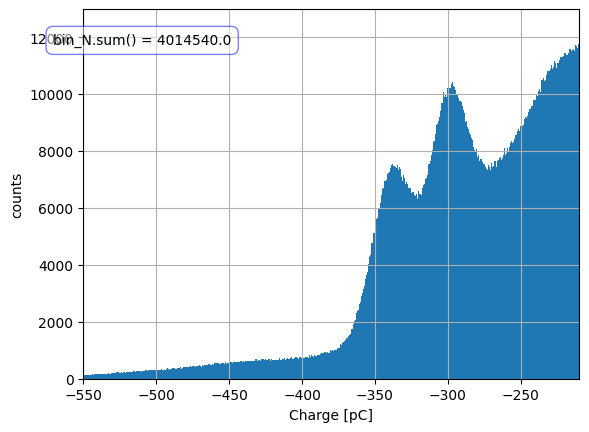

In [5]:
lim_N = [-550, -210]
plt.text(centers_N.min() * 0.85, bin_N.max() * 95 / 100, f'{bin_N.sum() = }', fontsize=10, color='black', ha='center',
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='round,pad=0.5'))
plt.bar(centers_N, bin_N)#, width = 1)
plt.xlim(lim_N)
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("counts")

In [6]:
err_N = err_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
bin_N = bin_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]
centers_N = centers_N[np.where((centers_N > lim_N[0]) & (centers_N < lim_N[1]))]

In [7]:
#DEFINIAMO IL MODELLO
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana

sigmoid1 = StepModel(form = "logistic", prefix = "s1_") #Sigmoide
sigmoid2 = StepModel(form = "logistic", prefix = "s2_") #Sigmoide
sigmoid3 = StepModel(form = "logistic", prefix = "s3_") #Sigmoide



params = exp1.guess(bin_N, x=centers_N)           #Inizializzo i parametri dell'esponenziale
params.update(sigmoid1.guess(bin_N, x=centers_N))
params.update(gauss1.make_params(amplitude = 0, center = -320, sigma = 25))   
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25))   

params.update(sigmoid2.make_params(amplitude = 0, center = -200, sigma = 50))
params.update(sigmoid3.make_params(amplitude = 0, center = -200, sigma = 50))



model = exp1 + gauss1 + gauss2 + sigmoid1 + sigmoid2 + sigmoid3

In [9]:
#CARICHIAMO I VALORI DI PARTENZA SU RUMORE
import pickle
channel = 7
with open("../DictNoise/NoisesDict_11_04.pkl", "rb") as f:
    noise_params = pickle.load(f)

if (channel <14):
    noise_params = noise_params[channel]
elif(channel==14):
    noise_params = noise_params[12]
elif(channel==15):
    noise_params = noise_params[13]

noise_params.pretty_print()

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      8835     -inf      inf    142.2     True     None     None
e1_decay        -89.38     -inf      inf    0.579     True     None     None
ratio            27.03     -inf      inf   0.7361    False e1_amplitude / s1_amplitude     None
s1_amplitude     326.9        0      inf    6.576     True     None     None
s1_center       -400.8     -inf      inf     1.05     True     None     None
s1_sigma         24.04        0      inf   0.7725     True     None     None


In [20]:
#IMPOSTIAMO I PARAMETRI
params["s1_amplitude"].min = 0
params["s2_amplitude"].min = 0
params["g1_amplitude"].min = 0
params["e1_amplitude"].min = 0

params["s1_amplitude"].value = noise_params["s1_amplitude"].value
params["s1_center"].value = noise_params["s1_center"].value
params["s1_sigma"].value = noise_params["s1_sigma"].value
params["e1_decay"].value = noise_params["e1_decay"].value
#params.add("ratio", value = noise_params["ratio"].value)
params["e1_amplitude"].set(vary=True, expr = "ratio * s1_amplitude")


params["g1_amplitude"].set(value = 100000, min=0 )   
params["g1_center"].set(value = -300)        
params["g1_sigma"].set(value = 14)

params["g2_amplitude"].set(value = 100000, min=0 )   
params["g2_center"].set(value = -360, min = -305 , max = -280)        
params["g1_center"].set(value = -340, min = -350 , max = -325)        


params["s2_amplitude"].set(value = 0, min=0, max = 4000)
params["s2_center"].set(value = -220, min = -300, max = 0)
params["s3_center"].set(value = -220, min = -300, max = 0)

params["s2_sigma"].set(value = 9)

params["e1_amplitude"].set(value = 6000, min=0)
params["s1_center"].set(value = -200, min=0, max = -375)

params["s1_amplitude"].set(value = 1046, min=0)
params["s1_sigma"].set(value = 50, min=0)
params["s1_center"].set(value = -450, min = -450)
params["s3_amplitude"].set(value = 100, min=0, max = 4000)





    

params.update(params)
params.pretty_print()


Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude      6000        0      inf     None    False     None     None
e1_decay        -89.38     -inf      inf     None     True     None     None
g1_amplitude     1e+05        0      inf     None     True     None     None
g1_center         -340     -350     -325     None     True     None     None
g1_fwhm          32.97     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height         2850     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma            14        0      inf     None     True     None     None
g2_amplitude     1e+05        0      inf     None     True     None     None
g2_center         -305     -305     -280     None     True     None     None
g2_fwhm          58.87     -inf      inf     None    False 2.3548200*g2_sigma     None
g2_height         1596     -inf      inf     None    False 0.3989423*g2_amplitude/max(1e-15, g2_

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


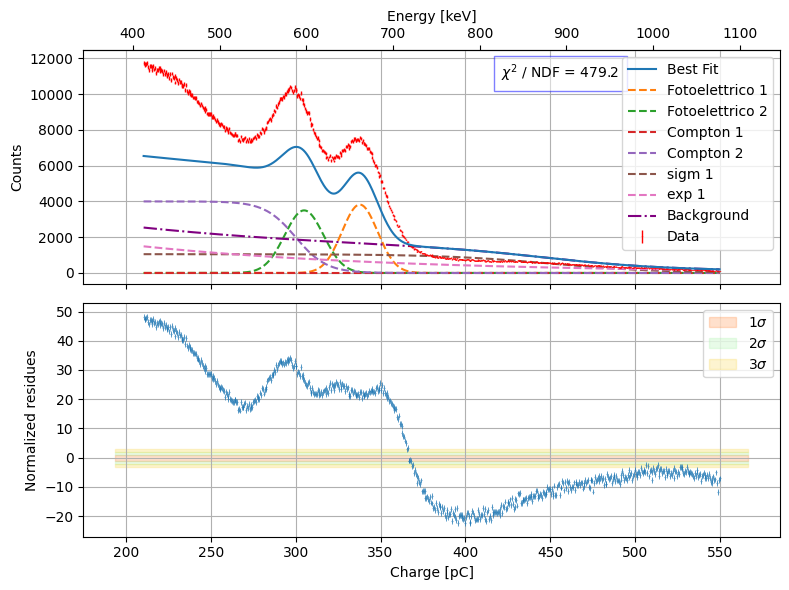

In [21]:
result = model.fit(bin_N, params, x = centers_N, weights = 1 / err_N, method= "ampgo")

def pCtoKev(x):
    return -x / result.params["g1_center"].value * 661.7

def KevtopC(x):
    return -x * result.params["g1_center"].value / 661.7


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6), sharex = True)


ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(-centers_N[::-1], result.best_fit[::-1], label='Best Fit', zorder = 10)
ax1.plot(-centers_N[::-1], comps['g1_'][::-1], label='Fotoelettrico 1', ls = "--")
ax1.plot(-centers_N[::-1], comps['g2_'][::-1], label='Fotoelettrico 2', ls = "--")
ax1.plot(-centers_N[::-1], comps['s2_'][::-1], label='Compton 1', ls = "--")
ax1.plot(-centers_N[::-1], comps['s3_'][::-1], label='Compton 2', ls = "--")
ax1.plot(-centers_N[::-1], comps['s1_'][::-1], label='sigm 1', ls = "--")
ax1.plot(-centers_N[::-1], comps['e1_'][::-1], label='exp 1', ls = "--")


ax1.plot(-centers_N[::-1], comps['e1_'][::-1] + comps['s1_'][::-1], label='Background', ls = "-.",
         color = "purple")


ax1.errorbar(-centers_N[::-1], bin_N[::-1], err_N[::-1], color = "red", fmt='|', linewidth = 1, 
             markersize = 0.5, label = "Data")

'''
dely = result.eval_uncertainty(sigma=1)
ax1.fill_between(-centers_N[::-1],
                        (result.best_fit-result.dely)[::-1],
                        (result.best_fit+result.dely)[::-1],
                        color="lightblue", alpha = 0.5, label = r'$1\sigma$ band')
'''
ax1.text(-np.mean(lim_N) * 1.2, bin_N.max(), r'$\chi^2$ / NDF = ' + str(round(result.redchi, 1)), 
         fontsize=10, color='black', ha = "center", va = "top", 
         bbox=dict(facecolor='white', alpha=0.5, edgecolor='blue', boxstyle='square,pad=0.5'))

ax1.grid()
ax1.legend()


residueCs = bin_N - result.best_fit
norm_resCs = residueCs / err_N

ax2.errorbar(-centers_N[::-1], norm_resCs[::-1], 1, ls = "", marker = ".", linewidth = 0.5, markersize = 0.5)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "#FF6700", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "#F7CB15", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "#F7CB15", alpha = 0.2)

ax2.legend()

secax = ax1.secondary_xaxis('top', functions=(pCtoKev, KevtopC))
secax.set_xlabel('Energy [keV]')

fig.tight_layout()

plt.show()

In [16]:
print(result.fit_report())

NameError: name 'result' is not defined

In [12]:
res_nrm = norm_resCs.sum()
res_bin, res_edg, _ = plt.hist(norm_resCs, density = True, bins = 9)
res_cntrs = np.convolve(res_edg, [0.5, 0.5], 'valid')
res_err = np.sqrt(res_bin * res_nrm) / res_nrm
plt.errorbar(res_cntrs, res_bin, res_err, ls = "")
res_x = np.arange(res_edg[0], res_edg[-1], 0.1)
plt.plot(res_x, 1 / np.sqrt(2 * np.pi) * np.exp(-res_x*res_x / 2))
plt.grid()

res_res = ((res_bin - 1 / np.sqrt(2 * np.pi) * np.exp(-res_cntrs*res_cntrs / 2)) / res_err)**2

NameError: name 'norm_resCs' is not defined

In [13]:
res_res.sum()

NameError: name 'res_res' is not defined

## Sistematiche

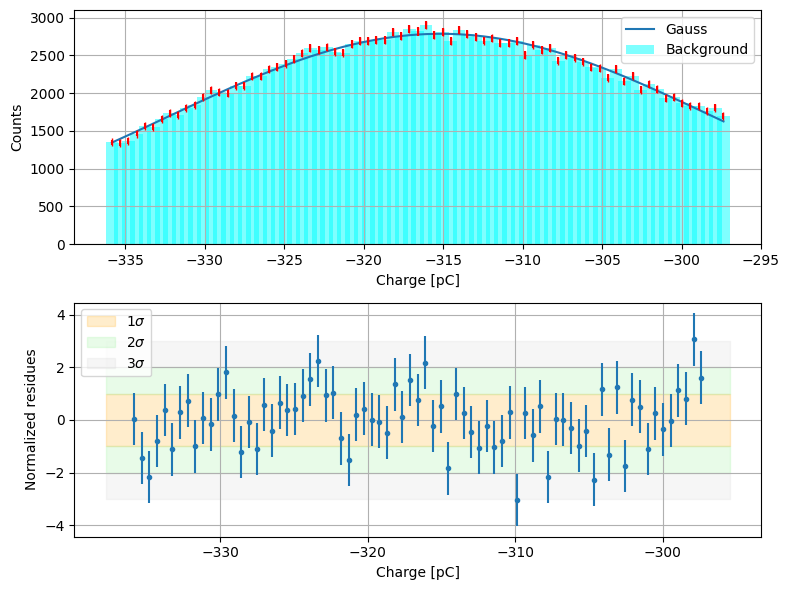

[[Model]]
    Model(gaussian, prefix='g3_')
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 75
    # variables        = 3
    chi-square         = 94.6247683
    reduced chi-square = 1.31423289
    Akaike info crit   = 23.4323362
    Bayesian info crit = 30.3848006
    R-squared          = 0.99999304
[[Variables]]
    g3_amplitude:  119709.115 +/- 684.170359 (0.57%) (init = 55829.28)
    g3_center:    -315.154744 +/- 0.08145003 (0.03%) (init = -315.04)
    g3_sigma:      17.1510378 +/- 0.13295983 (0.78%) (init = 11.96)
    g3_fwhm:       40.3876062 +/- 0.31309647 (0.78%) == '2.3548200*g3_sigma'
    g3_height:     2784.49799 +/- 10.9160375 (0.39%) == '0.3989423*g3_amplitude/max(1e-15, g3_sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(g3_amplitude, g3_sigma)  = +0.8734
    C(g3_amplitude, g3_center) = +0.2489
    C(g3_center, g3_sigma)     = +0.2366


In [ ]:
sist_lim_list = [[510, 605],  #ch0
                [-1, -1],  #ch1
                [460, 565],  #ch2
                [490, 585],  #ch3
                [350, 430],  #ch4
                [550, 630],  #ch5
                [550, 660],  #ch6
                [250, 350],  #ch7
                [500, 600],  #ch8
                [340, 470],  #ch9
                [180, 270],  #ch10
                [540, 630],  #ch11
                [-1, -1],  #ch12
                [-1, -1],  #ch13
                [460, 585],  #ch14
                [315, 390]   #ch15
                ]


sist_lims = sist_lim_list[channel]
sist_bin = bin_N[sist_lims[0]:sist_lims[1]]
sist_cntr = centers_N[sist_lims[0]:sist_lims[1]]
sist_err = np.sqrt(sist_bin)


gauss3 = GaussianModel(prefix='g3_')    #Gaussiana

params2 = gauss3.guess(sist_bin, x = sist_cntr)           #Inizializzo i parametri dell'esponenziale

model2 = gauss3

result2 = model2.fit(sist_bin, params2, x = sist_cntr, weights = 1 / sist_err, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.bar(sist_cntr, sist_bin, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result2.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(sist_cntr, comps['g3_'], label='Gauss')

ax1.legend()
ax1.errorbar(sist_cntr, sist_bin, sist_err, color = "red", fmt='|')
ax1.grid()

residueGauss = sist_bin - result2.best_fit
norm_res_gauss = residueGauss / sist_err

ax2.errorbar(sist_cntr, norm_res_gauss, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()


print(result2.fit_report())

In [ ]:
print(f'La sistematica è {result.params["g1_center"].value - result2.params["g3_center"].value}')

La sistematica è -0.660391823891473
